In [1]:
from __future__ import annotations

import datetime
import numpy as np
from pydantic import BaseModel
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class EmojiClassifierConfig(BaseModel):
    image_shape: tuple[int, int] = (256, 256)
    num_classes: int = 12
    batch_size: int = 32
    epochs: int = 10

    train_path: str = "../dataset/train"
    validation_path: str = "../dataset/validation"
    test_path: str = "../dataset/test"


class EmojiClassifier:
    def __init__(self, config: EmojiClassifierConfig, build_model = True):
        self.config = config
        if build_model:
            self.model = self.build_model()

        data_gen_args = dict(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
        )

        self.train_generator = ImageDataGenerator(**data_gen_args).flow_from_directory(
            self.config.train_path,
            target_size=self.config.image_shape,
            batch_size=self.config.batch_size,
            class_mode="categorical",
            color_mode="grayscale",
        )
        self.validation_generator = ImageDataGenerator().flow_from_directory(
            self.config.validation_path,
            target_size=self.config.image_shape,
            batch_size=self.config.batch_size,
            class_mode="categorical",
            color_mode="grayscale",
        )
        self.test_generator = ImageDataGenerator().flow_from_directory(
            self.config.test_path,
            target_size=self.config.image_shape,
            batch_size=self.config.batch_size,
            class_mode="categorical",
            color_mode="grayscale",
        )

    def build_model(self):
        model = models.Sequential(
            [
                layers.Conv2D(32, (3, 3), activation="relu", input_shape=(*self.config.image_shape, 1)),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(64, (3, 3), activation="relu"),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(128, (3, 3), activation="relu"),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(128, (3, 3), activation="relu"),
                layers.MaxPooling2D((2, 2)),
                layers.Flatten(),
                layers.Dense(512, activation="relu"),
                layers.Dense(self.config.num_classes, activation="softmax"),
            ]
        )

        model.compile(
            optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

        return model

    def train(self, epochs: int | None = None, batch_size: int | None = None):
        if not epochs:
            epochs = self.config.epochs
        if not batch_size:
            batch_size = self.config.batch_size

        history = self.model.fit(
            self.train_generator,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=self.validation_generator,
        )
        return history

    def evaluate(self):
        return self.model.evaluate(self.test_generator)

    def save(self, path: str):
        self.model.save(path)

    def load(self, path: str):
        self.model = models.load_model(path)

    def predict(self, image):
        return self.model.predict(image)

    def evaluate_another(self):
        incorrects = []
        for i in range(len(self.test_generator)):
            x_test, y_test = self.test_generator[i]
            y_pred = self.model.predict(x_test)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true_classes = np.argmax(y_test, axis=1)
            incorrects.extend(
                [
                    (x, p, t)
                    for x, p, t in zip(x_test, y_pred_classes, y_true_classes)
                    if p != t
                ]
            )
        return incorrects


def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()


2024-03-06 18:42:51.960800: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 18:42:52.025179: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 18:42:52.386082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 18:42:52.386134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 18:42:52.468882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
config = EmojiClassifierConfig()
classifier = EmojiClassifier(config)


Found 955 images belonging to 12 classes.
Found 203 images belonging to 12 classes.
Found 215 images belonging to 12 classes.


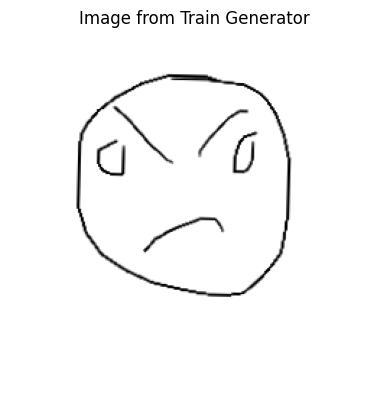

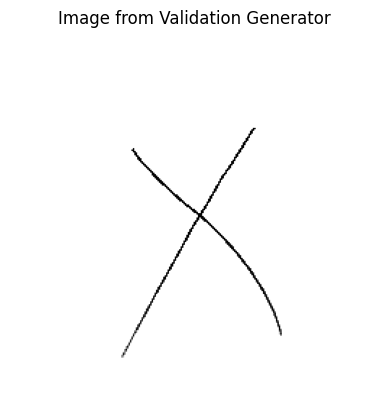

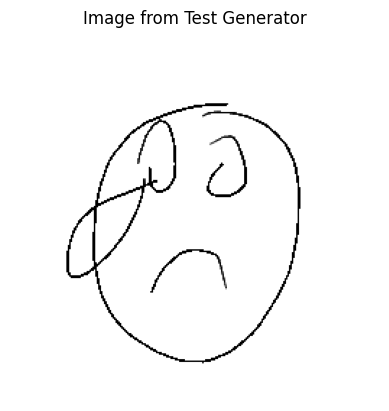

In [10]:
import matplotlib.pyplot as plt

x_train, y_train = next(classifier.train_generator)
plt.imshow(x_train[0].reshape(classifier.config.image_shape), cmap='gray')
plt.title('Image from Train Generator')
plt.axis('off')
plt.show()

x_validation, y_validation = next(classifier.validation_generator)
plt.imshow(x_validation[0].reshape(classifier.config.image_shape), cmap='gray')
plt.title('Image from Validation Generator')
plt.axis('off')
plt.show()

x_test, y_test = next(classifier.test_generator)
plt.imshow(x_test[0].reshape(classifier.config.image_shape), cmap='gray')
plt.title('Image from Test Generator')
plt.axis('off')
plt.show()


Found 955 images belonging to 12 classes.
Found 203 images belonging to 12 classes.
Found 215 images belonging to 12 classes.
Epoch 1/10
30/30 [==============================] - 19s 588ms/step - loss: 27.7506 - accuracy: 0.1047 - val_loss: 2.4844 - val_accuracy: 0.1084
Epoch 2/10
30/30 [==============================] - 18s 600ms/step - loss: 2.4842 - accuracy: 0.1016 - val_loss: 2.4831 - val_accuracy: 0.1084
Epoch 3/10
30/30 [==============================] - 20s 662ms/step - loss: 2.4825 - accuracy: 0.1047 - val_loss: 2.4817 - val_accuracy: 0.1084
Epoch 4/10
30/30 [==============================] - 20s 652ms/step - loss: 2.4879 - accuracy: 0.1037 - val_loss: 2.4803 - val_accuracy: 0.1084
Epoch 5/10
30/30 [==============================] - 19s 632ms/step - loss: 2.8859 - accuracy: 0.1079 - val_loss: 2.4795 - val_accuracy: 0.1084
Epoch 6/10
30/30 [==============================] - 20s 665ms/step - loss: 2.4796 - accuracy: 0.0974 - val_loss: 2.4786 - val_accuracy: 0.1084
Epoch 7/10
30/3

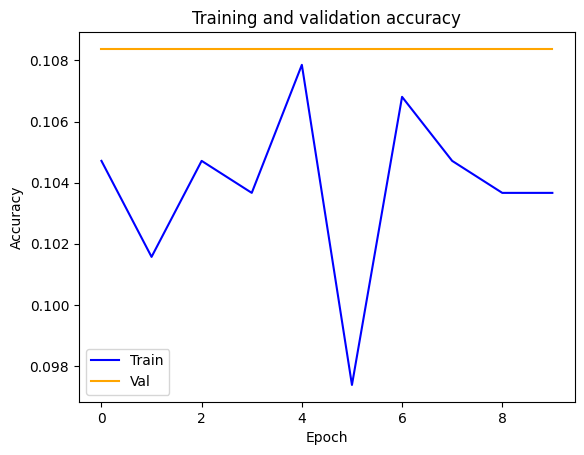

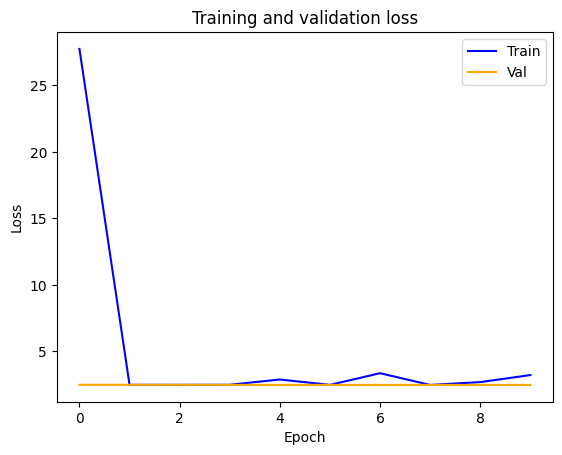

In [4]:
config = EmojiClassifierConfig(
    # In original size
)
classifier = EmojiClassifier(config)

history = classifier.train()
plot(history)
test_loss, test_accuracy = classifier.evaluate()
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss}")

import datetime
model_name = (
    f"../models/model-{'-'.join(map(str, classifier.config.image_shape))}"
    f"-{datetime.datetime.now().isoformat()}.keras"
)
classifier.save(model_name)

Found 955 images belonging to 12 classes.
Found 203 images belonging to 12 classes.
Found 215 images belonging to 12 classes.
Epoch 1/10
30/30 [==============================] - 5s 142ms/step - loss: 10.9855 - accuracy: 0.0827 - val_loss: 2.4632 - val_accuracy: 0.1084
Epoch 2/10
30/30 [==============================] - 4s 142ms/step - loss: 2.4765 - accuracy: 0.0984 - val_loss: 2.4001 - val_accuracy: 0.1626
Epoch 3/10
30/30 [==============================] - 4s 141ms/step - loss: 2.3176 - accuracy: 0.1979 - val_loss: 2.0673 - val_accuracy: 0.2857
Epoch 4/10
30/30 [==============================] - 4s 142ms/step - loss: 2.0035 - accuracy: 0.3026 - val_loss: 1.5621 - val_accuracy: 0.4384
Epoch 5/10
30/30 [==============================] - 4s 144ms/step - loss: 1.7818 - accuracy: 0.3801 - val_loss: 1.3294 - val_accuracy: 0.5419
Epoch 6/10
30/30 [==============================] - 5s 173ms/step - loss: 1.5890 - accuracy: 0.4586 - val_loss: 1.1825 - val_accuracy: 0.5862
Epoch 7/10
30/30 [===

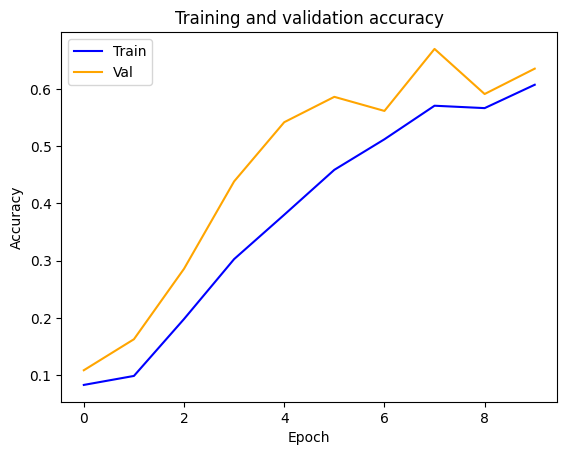

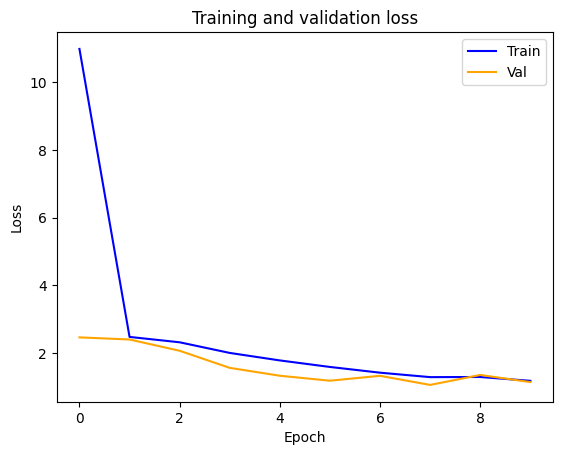

In [5]:
config = EmojiClassifierConfig(
    image_shape=(128, 128),  # 2 times
)
classifier = EmojiClassifier(config)

history = classifier.train()
plot(history)
test_loss, test_accuracy = classifier.evaluate()
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss}")

import datetime
model_name = (
    f"../models/model-{'-'.join(map(str, classifier.config.image_shape))}"
    f"-{datetime.datetime.now().isoformat()}.keras"
)
classifier.save(model_name)

Found 955 images belonging to 12 classes.
Found 203 images belonging to 12 classes.
Found 215 images belonging to 12 classes.
Epoch 1/10
30/30 [==============================] - 3s 69ms/step - loss: 6.7522 - accuracy: 0.0953 - val_loss: 2.5426 - val_accuracy: 0.0837
Epoch 2/10
30/30 [==============================] - 2s 64ms/step - loss: 2.4867 - accuracy: 0.1079 - val_loss: 2.3668 - val_accuracy: 0.2118
Epoch 3/10
30/30 [==============================] - 2s 62ms/step - loss: 2.3704 - accuracy: 0.2042 - val_loss: 2.4117 - val_accuracy: 0.1281
Epoch 4/10
30/30 [==============================] - 2s 67ms/step - loss: 2.1479 - accuracy: 0.2733 - val_loss: 2.0850 - val_accuracy: 0.3300
Epoch 5/10
30/30 [==============================] - 2s 64ms/step - loss: 1.9718 - accuracy: 0.3330 - val_loss: 1.7062 - val_accuracy: 0.4581
Epoch 6/10
30/30 [==============================] - 2s 65ms/step - loss: 1.7490 - accuracy: 0.4147 - val_loss: 1.6553 - val_accuracy: 0.4729
Epoch 7/10
30/30 [==========

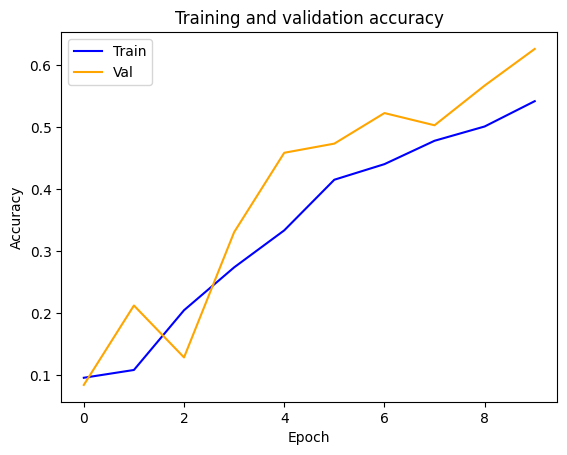

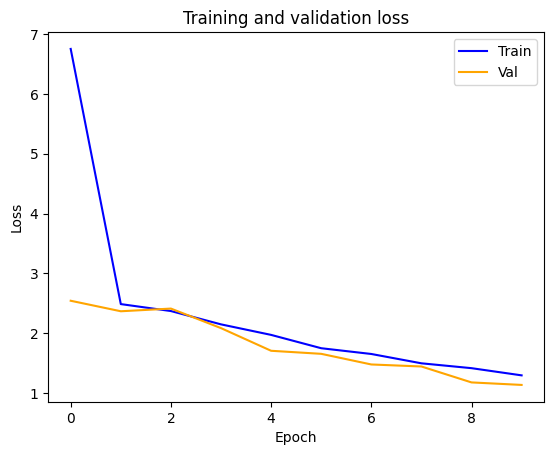

In [6]:
config = EmojiClassifierConfig(
    image_shape=(64, 64),  # 4 times
)
classifier = EmojiClassifier(config)

history = classifier.train()
plot(history)
test_loss, test_accuracy = classifier.evaluate()
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss}")

import datetime
model_name = (
    f"../models/model-{'-'.join(map(str, classifier.config.image_shape))}"
    f"-{datetime.datetime.now().isoformat()}.keras"
)
classifier.save(model_name)

Found 955 images belonging to 12 classes.
Found 203 images belonging to 12 classes.
Found 215 images belonging to 12 classes.
Epoch 1/10
30/30 [==============================] - 2s 44ms/step - loss: 21.9229 - accuracy: 0.0743 - val_loss: 2.4820 - val_accuracy: 0.0936
Epoch 2/10
30/30 [==============================] - 1s 44ms/step - loss: 2.4833 - accuracy: 0.0890 - val_loss: 2.4815 - val_accuracy: 0.0985
Epoch 3/10
30/30 [==============================] - 1s 44ms/step - loss: 2.4801 - accuracy: 0.0984 - val_loss: 2.4797 - val_accuracy: 0.0985
Epoch 4/10
30/30 [==============================] - 1s 45ms/step - loss: 2.4784 - accuracy: 0.0963 - val_loss: 2.4782 - val_accuracy: 0.1084
Epoch 5/10
30/30 [==============================] - 1s 45ms/step - loss: 2.4769 - accuracy: 0.1058 - val_loss: 2.4772 - val_accuracy: 0.1084
Epoch 6/10
30/30 [==============================] - 1s 45ms/step - loss: 2.4744 - accuracy: 0.1068 - val_loss: 2.6493 - val_accuracy: 0.0837
Epoch 7/10
30/30 [=========

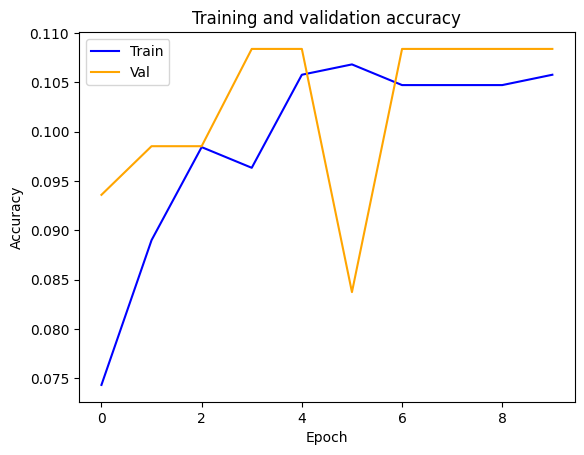

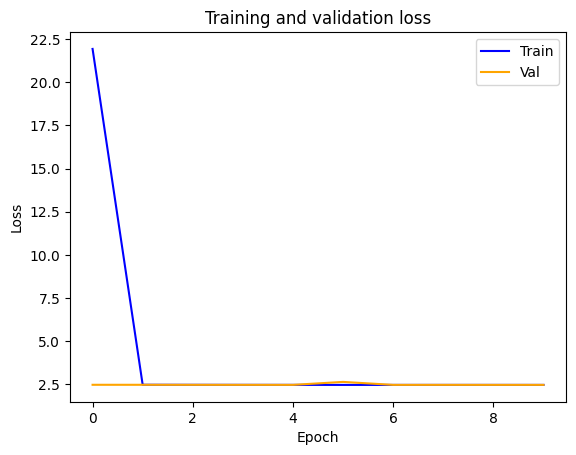

In [7]:
config = EmojiClassifierConfig(
    image_shape=(32, 32),  # 8 times
)
classifier = EmojiClassifier(config, build_model = False)

classifier.model = models.Sequential(
    [
        layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(*classifier.config.image_shape, 1)
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(classifier.config.num_classes, activation="softmax"),
    ]
)

classifier.model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


history = classifier.train()
plot(history)
test_loss, test_accuracy = classifier.evaluate()
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss}")

import datetime
model_name = (
    f"../models/model-{'-'.join(map(str, classifier.config.image_shape))}"
    f"-{datetime.datetime.now().isoformat()}.keras"
)
classifier.save(model_name)

Found 955 images belonging to 12 classes.
Found 203 images belonging to 12 classes.
Found 215 images belonging to 12 classes.
Epoch 1/10
30/30 [==============================] - 2s 42ms/step - loss: 13.9004 - accuracy: 0.0827 - val_loss: 2.9032 - val_accuracy: 0.1133
Epoch 2/10
30/30 [==============================] - 1s 37ms/step - loss: 2.5274 - accuracy: 0.1079 - val_loss: 2.5304 - val_accuracy: 0.1281
Epoch 3/10
30/30 [==============================] - 1s 35ms/step - loss: 2.4904 - accuracy: 0.1120 - val_loss: 2.5262 - val_accuracy: 0.0887
Epoch 4/10
30/30 [==============================] - 1s 35ms/step - loss: 2.4600 - accuracy: 0.1194 - val_loss: 2.4501 - val_accuracy: 0.1084
Epoch 5/10
30/30 [==============================] - 1s 37ms/step - loss: 2.4234 - accuracy: 0.1330 - val_loss: 2.4573 - val_accuracy: 0.1133
Epoch 6/10
30/30 [==============================] - 1s 39ms/step - loss: 2.4159 - accuracy: 0.1361 - val_loss: 2.4522 - val_accuracy: 0.1084
Epoch 7/10
30/30 [=========

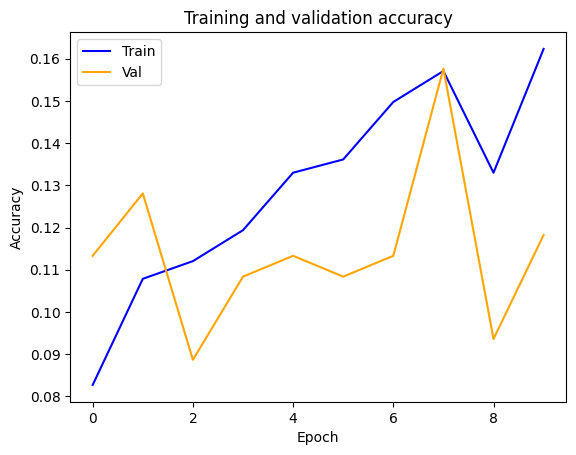

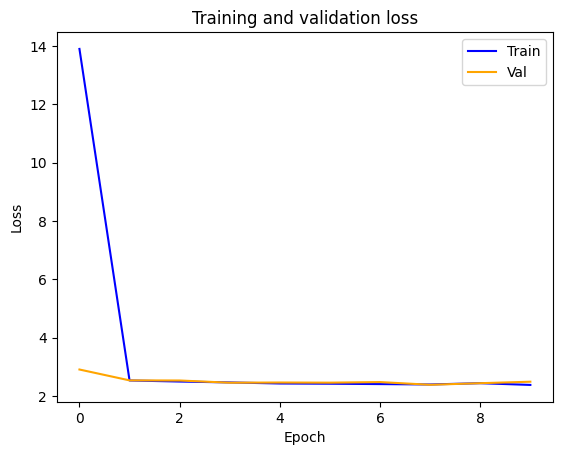

In [8]:
config = EmojiClassifierConfig(
    image_shape=(16, 16),  # 16 times
)
classifier = EmojiClassifier(config, build_model = False)

classifier.model = models.Sequential(
    [
        layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(*classifier.config.image_shape, 1)
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(classifier.config.num_classes, activation="softmax"),
    ]
)

classifier.model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = classifier.train()
plot(history)
test_loss, test_accuracy = classifier.evaluate()
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss}")

import datetime
model_name = (
    f"../models/model-{'-'.join(map(str, classifier.config.image_shape))}"
    f"-{datetime.datetime.now().isoformat()}.keras"
)
classifier.save(model_name)